In [104]:
# upload audio file

path = '../audio_files/Jeev2.wav'

In [106]:
num_speakers = 2 #@param {type:"integer"}

language = 'English' #@param ['any', 'English']

model_size = 'large' #@param ['tiny', 'base', 'small', 'medium', 'large']


model_name = model_size
if language == 'English' and model_size != 'large':
  model_name += '.en'

In [8]:
%pip install -q git+https://github.com/openai/whisper.git > /dev/null
%pip install -q git+https://github.com/pyannote/pyannote-audio > /dev/null
%pip install -U speechbrain==0.5.16

import whisper
import datetime

import subprocess

import torch
import pyannote.audio
import speechbrain
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
embedding_model = PretrainedSpeakerEmbedding(
    "speechbrain/spkrec-ecapa-voxceleb",
    device=torch.device("cuda"))

# from diart.blocks import OverlapAwareSpeakerEmbedding
# embedding_model = OverlapAwareSpeakerEmbedding.from_pyannote("pyannote/embedding")

from pyannote.audio import Audio
from pyannote.core import Segment

import wave
import contextlib

from sklearn.cluster import AgglomerativeClustering
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


/home/vhada/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [107]:
if path[-3:] != 'wav':
  subprocess.call(['ffmpeg', '-i', path, 'jeev2.wav', '-y'])
  path = 'jeev2.wav'

In [9]:
model = whisper.load_model(model_size)

In [108]:
result = model.transcribe(path)
segments = result["segments"]

In [109]:
with contextlib.closing(wave.open(path,'r')) as f:
  frames = f.getnframes()
  rate = f.getframerate()
  duration = frames / float(rate)

In [110]:
audio = Audio()

def segment_embedding(segment):
  start = segment["start"]
  # Whisper overshoots the end timestamp in the last segment
  end = min(duration, segment["end"])
  clip = Segment(start, end)
  waveform, sample_rate = audio.crop(path, clip)
  print(waveform.shape)
    # Check if the waveform has more than one channel
  if waveform.shape[0] > 1:
     print( waveform.shape)
   # Take the mean of the channels to create a mono waveform
     waveform = waveform.mean(axis=0)
  # Add an extra dimension to the waveform array
     waveform = waveform[None, :]
     print( waveform.shape)
  return embedding_model(waveform[None])

In [111]:
embeddings = np.zeros(shape=(len(segments), 192))
for i, segment in enumerate(segments):
  embeddings[i] = segment_embedding(segment)

embeddings = np.nan_to_num(embeddings)
print(embeddings)

torch.Size([1, 206400])
torch.Size([1, 54720])
torch.Size([1, 145920])
torch.Size([1, 120001])
torch.Size([1, 167040])
torch.Size([1, 165120])
torch.Size([1, 183360])
torch.Size([1, 160320])
[[ 25.97743225   0.28475222  14.14844227 ...  20.33265305 -11.29952049
   12.14350605]
 [-20.81703186 -31.03956795 -49.60467911 ...  34.40565872  16.13179588
    8.86119652]
 [ 24.60037422 -10.33181667 -12.18881607 ...  27.92990875   8.40309238
   28.54750252]
 ...
 [ 19.04681778  15.69022846   8.48542023 ...  28.91797447 -11.62731838
    6.06736517]
 [ 28.3519516   -3.2769835  -13.94839478 ...  17.50438309 -17.00576973
   14.3719244 ]
 [  9.30466557   8.08807468   0.81212306 ...  18.233181   -15.8226099
   35.22169113]]


In [143]:
import numpy as np

def euclidean_distance_np(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    distance = np.linalg.norm(point1 - point2)
    return distance


#returns the closest speaker 
def speaker_assignment(point, s1, s2):
  
    distance1 = euclidean_distance_np(point, s1)
    distance2 = euclidean_distance_np(point, s2)

    # print(distance1)
    # print(distance2)

    if distance1 > distance2:
        s_id = 1
    else:
        s_id = 0
    
    return s_id



In [145]:
from sklearn.decomposition import PCA
import ast


clustering = AgglomerativeClustering(num_speakers).fit(embeddings)
labels = clustering.labels_
print(labels)

pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)
# Initialize an empty list to store lines
lines = []

# Open the file in read mode
with open("output.txt", "r") as file:
    # Read each line one by one
    for line in file:
        lines.append(line.strip())  # Append the line to the list after stripping newline character

names = []
avgs = []
# Print the lines
for line in lines:
  avg = []
  newline = line.split(' ', 2)
  names.append(newline[0])
  avg.extend([
     ast.literal_eval(
        newline[1]),
      ast.literal_eval(
        newline[2])
         ])  
  avgs.append(avg)
  
print(avg[0])



for i in range(len(segments)):
  Speaker_num = speaker_assignment(embeddings_2d[i], avgs[0], avgs[1])
  #print(Speaker_num)
  segments[i]["speaker"] = names[Speaker_num] + ' ' + str(Speaker_num + 1)
  #segments[i]["speaker"] = 'SPEAKER ' + str(labels[i] + 1)

[1 0 1 0 1 0 1 0]
113.78900692


In [146]:
def time(secs):
  return datetime.timedelta(seconds=round(secs))

f = open("transcript.txt", "w")
x = ""
for (i, segment) in enumerate(segments):
  if i == 0 or segments[i - 1]["speaker"] != segment["speaker"]:
    f.write("\n" + segment["speaker"] + ' ' + str(time(segment["start"])) + '\n')
  f.write(segment["text"][1:] + ' ')
  x += "\n" + segment["speaker"] + ' ' + str(time(segment["start"])) + '\n'
  x += segment["text"][1:] + ' '
f.close()

In [147]:
print(open('transcript.txt').read())


Vishal 2 0:00:00
Hey, did you hear about the new policy change at work? 
Hasan 1 0:00:05
No, what's going on? 
Vishal 2 0:00:07
Starting next month, we can work from home two days a week. 
Hasan 1 0:00:11
That's awesome. I've been wanting more flexibility. 
Vishal 2 0:00:15
Me too. It's going to make balancing everything so much easier. 
Hasan 1 0:00:19
Absolutely. Plus, avoiding the commute twice a week will be great. 
Vishal 2 0:00:24
Totally. Let's plan to grab lunch on one of those home days. 
Hasan 1 0:00:28
Sounds like a plan. I'll look forward to it. 


In [148]:
print(x)


Vishal 2 0:00:00
Hey, did you hear about the new policy change at work? 
Hasan 1 0:00:05
No, what's going on? 
Vishal 2 0:00:07
Starting next month, we can work from home two days a week. 
Hasan 1 0:00:11
That's awesome. I've been wanting more flexibility. 
Vishal 2 0:00:15
Me too. It's going to make balancing everything so much easier. 
Hasan 1 0:00:19
Absolutely. Plus, avoiding the commute twice a week will be great. 
Vishal 2 0:00:24
Totally. Let's plan to grab lunch on one of those home days. 
Hasan 1 0:00:28
Sounds like a plan. I'll look forward to it. 


In [149]:
print(result)

{'text': " Hey, did you hear about the new policy change at work? No, what's going on? Starting next month, we can work from home two days a week. That's awesome. I've been wanting more flexibility. Me too. It's going to make balancing everything so much easier. Absolutely. Plus, avoiding the commute twice a week will be great. Totally. Let's plan to grab lunch on one of those home days. Sounds like a plan. I'll look forward to it.", 'segments': [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 4.3, 'text': ' Hey, did you hear about the new policy change at work?', 'tokens': [50365, 1911, 11, 630, 291, 1568, 466, 264, 777, 3897, 1319, 412, 589, 30, 50580], 'temperature': 0.0, 'avg_logprob': -0.18030848869910607, 'compression_ratio': 1.516, 'no_speech_prob': 0.0836244598031044, 'speaker': 'Vishal 2'}, {'id': 1, 'seek': 0, 'start': 4.9, 'end': 6.04, 'text': " No, what's going on?", 'tokens': [50610, 883, 11, 437, 311, 516, 322, 30, 50667], 'temperature': 0.0, 'avg_logprob': -0.18030848869910607

[[ 108.00620026   48.39236936]
 [-197.09222517  -77.97479273]
 [  48.46044191  -71.53172573]
 [-124.47184551   -5.65673007]
 [ 154.07263285  -53.40759564]
 [ -18.32507682   91.15271141]
 [  74.65093016  -40.07083683]
 [ -45.30105767  109.09660023]]


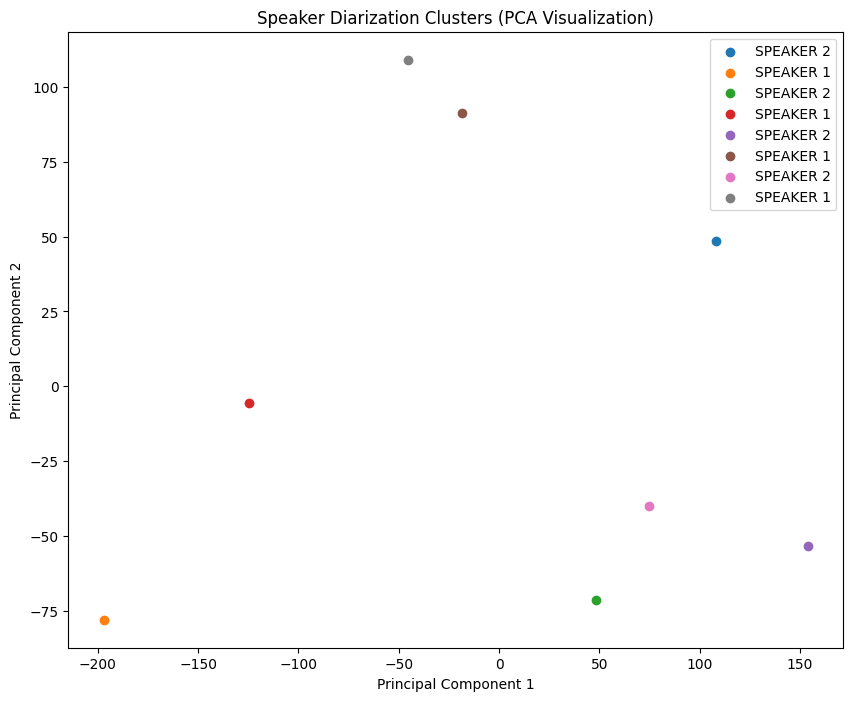

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Your existing code for clustering and labeling segments...

# Perform PCA to reduce the dimensionality of embeddings to 2D
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

print(embeddings_2d)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i, segment in enumerate(segments):
    speaker_id = labels[i] + 1
    x, y = embeddings_2d[i]
    plt.scatter(x, y, label=f'SPEAKER {speaker_id}')

plt.title("Speaker Diarization Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


[-96.29755129  29.15444721]
[ 96.29755129 -29.15444721]


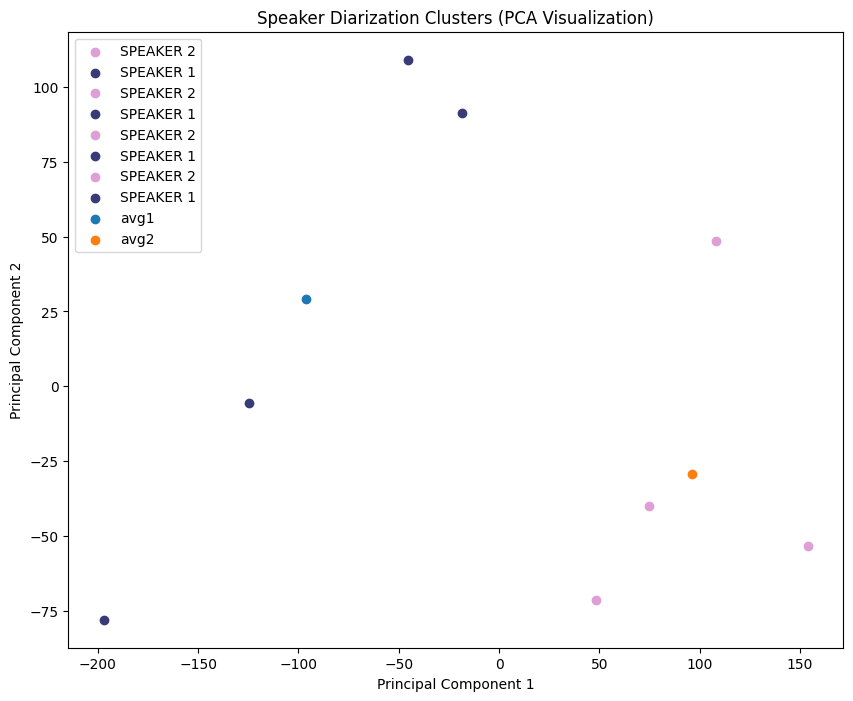

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Your existing code for clustering and labeling segments...
# labels = clustering.labels_
# print(labels)
# for i in range(len(segments)):
#   segments[i]["speaker"] = 'SPEAKER ' + str(labels[i] + 1)

# Perform PCA to reduce the dimensionality of embeddings to 2D
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)


# Calculate the average point
average_point = np.mean(embeddings_2d, axis=0)
speaker_1 = []
speaker_2 = []

# Get the number of unique speakers from the labels
num_unique_speakers = len(np.unique(labels))

# Create a colormap for speakers, ensuring each speaker gets a unique color
colors = cm.tab20b(np.linspace(0, 1, num_unique_speakers))

# split by speakers to get avg
for i, segment in enumerate(segments):
    speaker_id = labels[i] + 1
    if speaker_id == 1:
        speaker_1.append(embeddings_2d[i]) # Get speaker one coords
    else:
        speaker_2.append(embeddings_2d[i]) # Get speaker two
    #plt.scatter(x, y, label=f'SPEAKER {speaker_id}', color=color)

avg1 = np.mean(speaker_1, axis=0) #Get average of speaker one coords
avg2 = np.mean(speaker_2, axis=0)

#PLot the clusters 
plt.figure(figsize=(10, 8))
for i, segment in enumerate(segments):
    speaker_id = speaker_assignment(embeddings_2d[i], avg1, avg2) + 1
    x, y = embeddings_2d[i]
    color = colors[speaker_assignment(embeddings_2d[i], avg1, avg2) % num_unique_speakers]  # Get the corresponding color for the speaker
    plt.scatter(x, y, label=f'SPEAKER {speaker_id}', color=color)

# #Find total distances
# total1 = 0
# total2 = 0
# for i, points in enumerate(speaker_2):
#    total1 = total1 + euclidean_distance_np(avg1,speaker_2[i] )
#    total2 = total1 + euclidean_distance_np(avg2,speaker_2[i] )


# print(f'1 {total1} ')
# print(f'2 {total2} ')

print(avg1)
print(avg2)
# with open('output.txt', 'w') as f:  #Write averages to textfile and save speaker profile
#     f.write(f'Hasan {avg1[0]} {avg1[1]}')
#     f.write('\n')
#     f.write(f'Vishal {avg2[0]} {avg2[1]}')
#     f.close()

#plt.scatter(average_point[0], average_point[1],label="avg" )
plt.scatter(avg1[0], avg1[1],label="avg1" )
plt.scatter(avg2[0], avg2[1],label="avg2" )
plt.title("Speaker Diarization Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


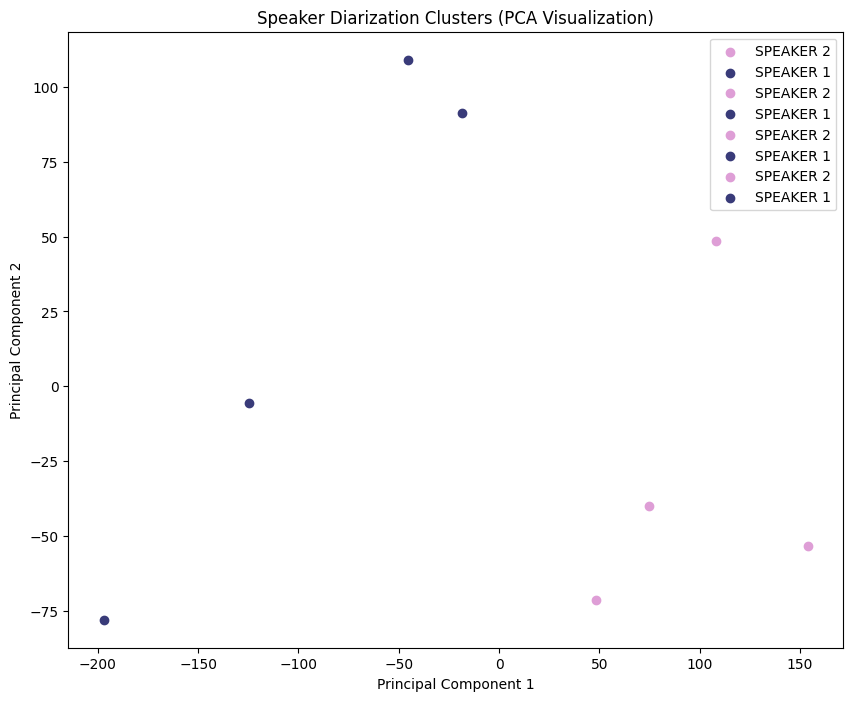

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Your existing code for clustering and labeling segments...

# Perform PCA to reduce the dimensionality of embeddings to 2D
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Get the number of unique speakers from the labels
num_unique_speakers = len(np.unique(labels))

# Create a colormap for speakers, ensuring each speaker gets a unique color
colors = cm.tab20b(np.linspace(0, 1, num_unique_speakers))

# Plot the clusters
plt.figure(figsize=(10, 8))
for i, segment in enumerate(segments):
    speaker_id = labels[i] + 1
    x, y = embeddings_2d[i]
    color = colors[labels[i] % num_unique_speakers]  # Get the corresponding color for the speaker
    plt.scatter(x, y, label=f'SPEAKER {speaker_id}', color=color)

plt.title("Speaker Diarization Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

In [86]:
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Your existing code for clustering and labeling segments...

# Perform PCA to reduce the dimensionality of embeddings to 3D
pca = PCA(n_components=3, random_state=42)
embeddings_3d = pca.fit_transform(embeddings)

# Get the number of unique speakers from the labels
num_unique_speakers = len(np.unique(labels))

# Create a colormap for speakers, ensuring each speaker gets a unique color
colors = cm.tab20b(np.linspace(0, 1, num_unique_speakers))

# Prepare the data for the 3D scatter plot
data = []
for i, segment in enumerate(segments):
    speaker_id = labels[i] + 1
    x, y, z = embeddings_3d[i]
    color = colors[labels[i] % num_unique_speakers]  # Get the corresponding color for the speaker
    trace = go.Scatter3d(x=[x], y=[y], z=[z], mode='markers',
                         marker=dict(size=5, color=color),
                         name=f'SPEAKER {speaker_id}')
    data.append(trace)

# Layout for the 3D scatter plot
layout = go.Layout(
    title="Speaker Diarization Clusters (3D Visualization)",
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3"
    )
)

# Create the figure and plot the 3D scatter plot
fig = go.Figure(data=data, layout=layout)
fig.show()


ModuleNotFoundError: No module named 'plotly'